# Differential Capacity Hysteresis State model

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import pybamm

Note: you may need to restart the kernel to use updated packages.


## Model Equations

Herein, we outline the equations for the Differential Capacity Hysteresis State open-circuit potential model, as described in Wycisk (2022), and the Hysteresis State open-circuit potential model, as described in Axen (2022).

### Hysteresis State Variable (Wycisk)

This approach utilizes a state variable to represent the degree of hysteresis at a given time and stoichiometry, $h(z,t)$. The hysteresis is treated separately from the open-circuit potential, where the potential of the electrode is written as

$$ U = U_{avg}^0(z) + H(z) \cdot h(z,t) - \eta $$

Where $H(z)$ is a function representing the hysteresis as a function of stoichiometry, $z$, and where $\eta$ represents the sum of the overpotentials. $U_{avg}^0(z)$ is simply the average of the delithiation and lithiation open-circuit potential branches. $H(z)$ can be determined by finding the half-difference value between the lithiation and delithiation branches across the entire stoichiometry range. The state variable $h(z,t)$ is both stoichiometry and time-dependant, and spans between the range of -1 and 1. The hysteresis state variable $h(z,t)$ can be expressed in differential form with respect to time as

$$ \frac{dh(z,t)}{dt} = \left(\frac{k(z) \cdot I(t)}{Q_{cell}}\right)\left(1-\text{sgn}\left(\frac{dz(t)}{dt}\right) h(z,t)\right) $$

where $ k(z) $ is expressed as 

$$ k(z) = K \cdot \frac{1}{\left(C_{diff}\left(z\right)\right)^{x}} $$

And where $C_{diff}(z)$ is the differential capacity with respect to potential, expressed as 

$$ C_{diff}(z) = \frac{dQ}{dU_{avg}^0(z)} $$

Here, $Q$ is the capacity of the phase or active material experiencing the voltage hysteresis. The remaining parameters are $K$ and $x$ which are both fitting parameters that affect the response of the hysteresis state decay when passing charge in either direction.

### Hysteresis State Variable (Axen)

Similar to the Wycisk's approach, this method uses a state variable to combine the lithiation and delithiation branches of the open-circuit potential, which are measured empirically and are provided as input parameters to the model.

The method reported by Axen (2022) defines the open-circuit potential as:

$$ U = U_{delith} + (U_{lith} - U_{delith}) \, h(z,t) $$

which implies that $U$ moves towards the delithiation branch $U_{delith}$ when $h(z,t)$ approaches 0 and the lithiation branch $U_{lith}$ when $h(z,t)$ approaches 1. The corresponding ODE system is formulated as:

$$ \frac{dh(z,t)}{dt} = K_{lith} \, \frac{I_{cell}}{Q_{cell}} \, (1 - h(z,t)) \qquad \text{for lithiation}$$
$$ \frac{dh(z,t)}{dt} = K_{delith} \, \frac{I_{cell}}{Q_{cell}} \, h(z,t)^a \qquad \text{for delithiation}$$

where $I_{cell}$ is the cell current, $Q_{cell}$ is the cell capacity, and $K_{lith}$ and $K_{delith}$ are the decay rates for lithiation and delithiation, respectively. The value of the exponent $a$ can be varied to best fit the problem at hand; at present we choose $a = 1$, but future implementations could include $a$ as an input parameter. It is important to highlight that in this form, we need to adjust the sign of the ODE system depending on whether the hysteresis occurs in the anode or in the cathode to align with the sign of the applied current $I_{cell}$.

However, we desire an ODE system with a sign that is invariant to the change in the direction of the applied current. This is achieved by replacing $I_{cell}/Q_{cell}$ with $i_{vol} / (F \, c_{max} \, \epsilon)$ to obtain a general expression that can be applied to both lithiation and delithiation, without the need of adjusting the sign of the formulation, with $a=1$:

$$ \frac{dh(z,t)}{dt} =  -K' \, \left(\frac{1-\text{sgn}(i_{vol})}{2} + \text{sgn}(i_{vol}) \, h(z,t)\right)$$

$$K' = \frac{i_{vol}}{F \, c_{max} \, \epsilon} \, \left( \frac{1-\text{sgn}(i_{vol})}{2} \, K_{lith} + \frac{1+\text{sgn}(i_{vol})}{2} \, K_{delith}\right)$$

where $i_{vol}$ is the volumetric interfacial current density of the active material particles showing hysteresis, which is always negative for lithiation and positive for delithiation, regardless of whether these particles are in the anode or in the cathode; $F$ is the Faraday constant, $c_{max}$ is the maximum lithium concentration in the particles and $\epsilon$ is the active material volume fraction.

The expression to calculate $U$ and the corresponding ODE system is further modified to ensure $h(z,t)$ varies between -1 and 1, thus assuming the same variation range as in the Wycisk's model.

The modified equation for $U$ is written as:

$$ U = U_{delith} + \frac{(U_{lith} - U_{delith}) \, (1 - h(z,t))}{2} $$

In this expression, $U$ converges to $U_{lith}$ when $h(z,t)$ approaches -1 and $U_{delith}$ when $h(z,t)$ approaches 1.

The modified ODE system is:

$$ \frac{dh(z,t)}{dt} = K' \, (1 - \text{sgn}(i_{vol}) \, h(z,t))$$


## Comparing the DCHS, HS and Current-Sigmoid model approaches

The behavior of the DCHS and HS models is different than the current-sigmoid model approach for open-circuit potential in systems with hysteresis. Where the current-sigmoid model switches between hysteresis states simply based on the instantaneous current, the DCHS and HS models switch based on the amount of charge passed through the active material phase while also relying on the previous hysteresis state. To assess this differentiated performance, we will compare them to the current-sigmoid model by adapting the Chen2020_composite parameter set.

First we generate the model, and specify the open-circuit potential methods for the negative and positive electrodes. To maintain consistency with the parameter set, two phases for the negative electrode will be defined.

In [2]:
model_DCHS = pybamm.lithium_ion.DFN(
    {
        "open-circuit potential": (("single", "Wycisk"), "single"),
        "particle phases": ("2", "1"),
    }
)

model_HS = pybamm.lithium_ion.DFN(
    {
        "open-circuit potential": (("single", "Axen"), "single"),
        "particle phases": ("2", "1"),
    }
)

model_current_sigmoid = pybamm.lithium_ion.DFN(
    {
        "open-circuit potential": (("single", "current sigmoid"), "single"),
        "particle phases": ("2", "1"),
    }
)

Next, lets define the modifications to the parameter set

In [3]:
parameters_DCHS = pybamm.ParameterValues("Chen2020_composite")
parameters_HS = pybamm.ParameterValues("Chen2020_composite")
parameters_current_sigmoid = pybamm.ParameterValues("Chen2020_composite")


# get the lithiation and delithiation functions
lithiation_ocp = parameters_DCHS["Secondary: Negative electrode lithiation OCP [V]"]
delithiation_ocp = parameters_DCHS["Secondary: Negative electrode delithiation OCP [V]"]


# define an additional OCP function
def ocp_avg(sto):
    return (lithiation_ocp(sto) + delithiation_ocp(sto)) / 2


# add additional parameters
parameters_DCHS.update(
    {
        "Secondary: Negative electrode OCP [V]": ocp_avg,
    },
    check_already_exists=False,
)

Next, we need to add the additional parameters required by the model. In this example, $K_{lith} = K_{delith} = 100$ for the HS model, but it is recommended to test different values for the decay rate aiming for good agreement to experiment if the information is available, or a smooth transition between the lithiation and delithiation branches of the hysteresis. For example, depending on the case study, an acceptable value for $K_{lith}$ and $K_{delith}$ could be $10$ or lower.

In [4]:
parameters_DCHS.update(
    {
        "Secondary: Negative particle hysteresis decay rate": 0.005,
        "Secondary: Negative particle hysteresis switching factor": 10,
        "Secondary: Initial hysteresis state in negative electrode": 0,
    },
    check_already_exists=False,
)

parameters_HS.update(
    {
        "Secondary: Negative particle lithiation hysteresis decay rate": 100,
        "Secondary: Negative particle delithiation hysteresis decay rate": 100,
        "Secondary: Initial hysteresis state in negative electrode": 0,
    },
    check_already_exists=False,
)

experiment = pybamm.Experiment(
    [
        ("Discharge at 1C for 1 hour or until 2.5 V", "Rest for 15 minutes"),
        (
            "Charge at 1C until 4.2 V",
            "Hold at 4.2 V until 0.05 C",
            "Rest for 15 minutes",
        ),
    ]
)


simulation_dchs = pybamm.Simulation(
    model_DCHS, experiment=experiment, parameter_values=parameters_DCHS
)
solution_dchs = simulation_dchs.solve(calc_esoh=False)

simulation_hs = pybamm.Simulation(
    model_HS, experiment=experiment, parameter_values=parameters_HS
)
solution_hs = simulation_hs.solve(calc_esoh=False)

simulation_current_sigmoid = pybamm.Simulation(
    model_current_sigmoid,
    experiment=experiment,
    parameter_values=parameters_current_sigmoid,
)

solution_current_sigmoid = simulation_current_sigmoid.solve(calc_esoh=False)

Now plotting the results and the hysteresis state.

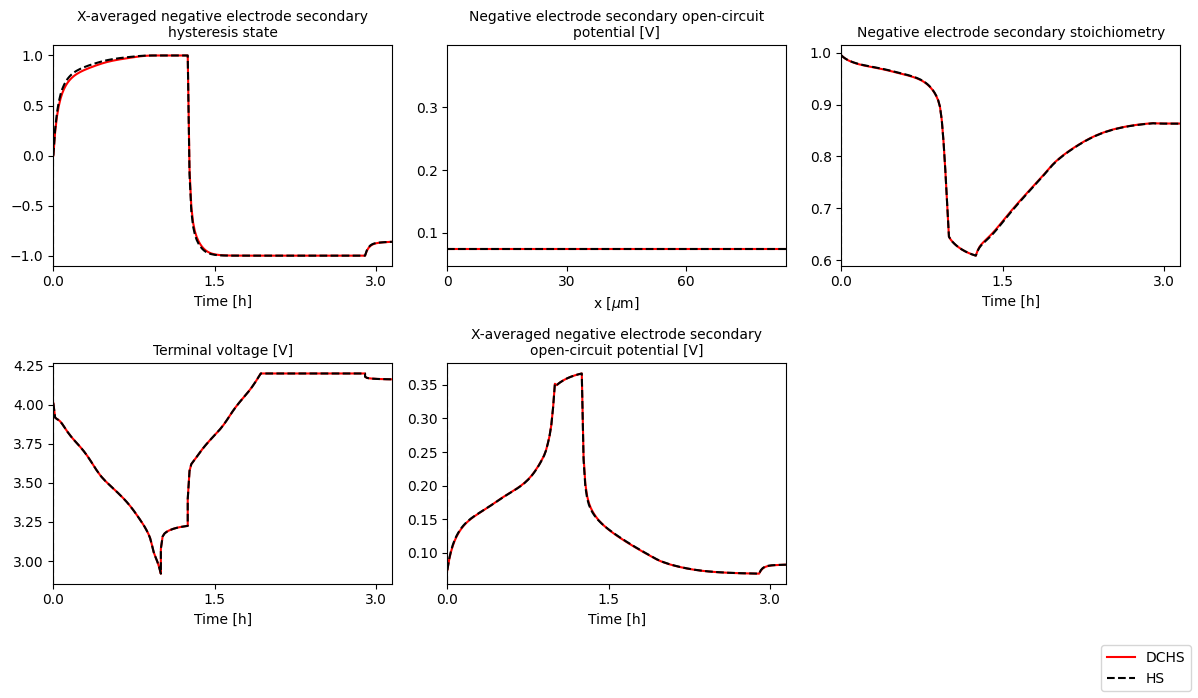

In [5]:
output_variables = [
    "X-averaged negative electrode secondary hysteresis state",
    "Negative electrode secondary open-circuit potential [V]",
    "Negative electrode secondary stoichiometry",
    "Terminal voltage [V]",
    "X-averaged negative electrode secondary open-circuit potential [V]",
]

pybamm.QuickPlot(
    [solution_dchs, solution_hs],
    labels=["DCHS", "HS"],
    colors=["red", "black"],
    linestyles=["solid", "dashed"],
    output_variables=output_variables,
).plot(0)

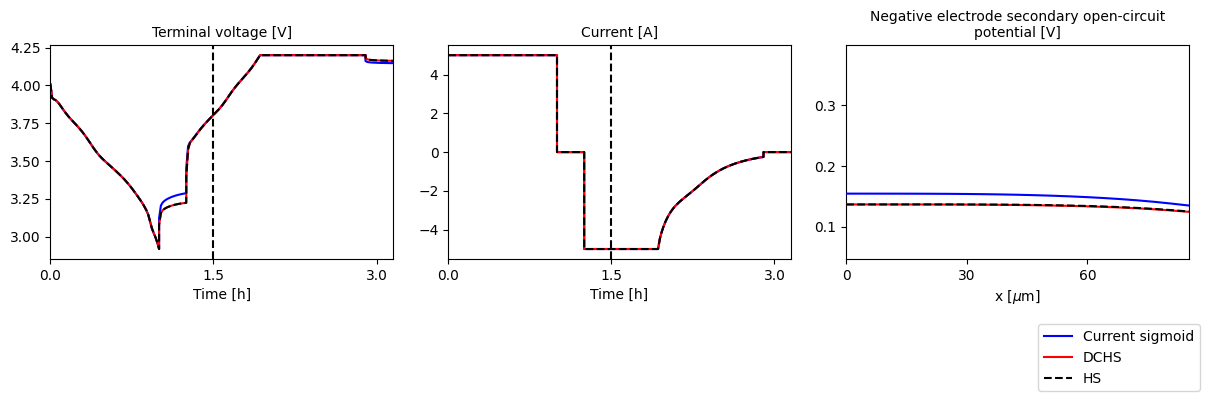

In [6]:
output_variables = [
    "Terminal voltage [V]",
    "Current [A]",
    "Negative electrode secondary open-circuit potential [V]",
]
pybamm.QuickPlot(
    [solution_current_sigmoid, solution_dchs, solution_hs],
    labels=["Current sigmoid", "DCHS", "HS"],
    colors=["blue", "red", "black"],
    linestyles=["solid", "solid", "dashed"],
    output_variables=output_variables,
).plot(1.5)